1) Import + Load cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load cleaned dataset
file_path = "../data/processed/online_retail_cleaned.csv"
df = pd.read_csv(file_path)

# แปลงวันที่ให้เป็น datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


2) กำหนด Snapshot Date (วันสุดท้ายของข้อมูล + 1 วัน)
    RFM จะวัดความใหม่ของลูกค้า → ต้องมีวันอ้างอิง

In [2]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
snapshot_date


Timestamp('2011-12-10 12:50:00')

3) คำนวณ R, F, M

In [3]:
rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,   # Recency
    "Invoice": "nunique",                                      # Frequency
    "TotalPrice": "sum"                                        # Monetary
})

rfm.rename(columns={
    "InvoiceDate": "Recency",
    "Invoice": "Frequency",
    "TotalPrice": "Monetary"
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,529,11,372.86
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


4) ตรวจการกระจายตัวของแต่ละ metric

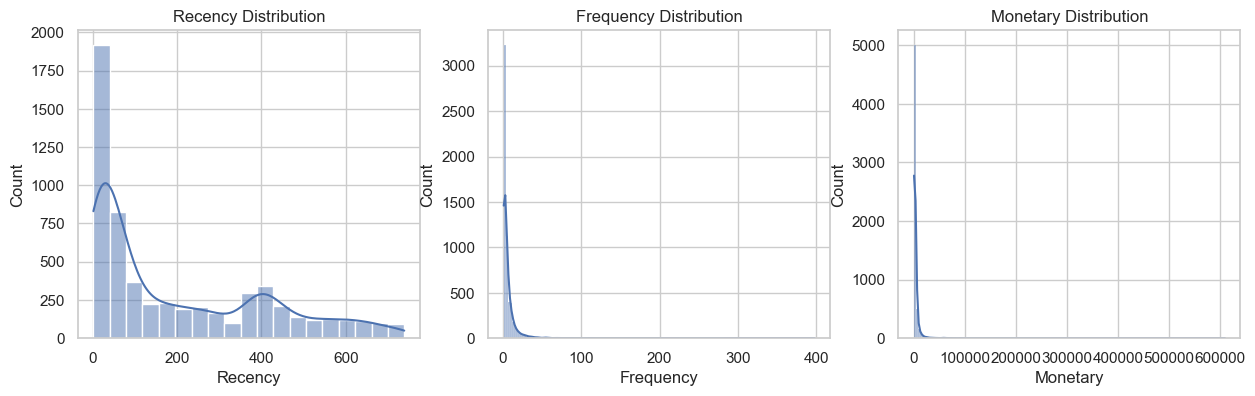

In [4]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.histplot(rfm["Recency"], kde=True)
plt.title("Recency Distribution")

plt.subplot(1,3,2)
sns.histplot(rfm["Frequency"], kde=True)
plt.title("Frequency Distribution")

plt.subplot(1,3,3)
sns.histplot(rfm["Monetary"], kde=True)
plt.title("Monetary Distribution")

plt.show()


5) กำหนด Quantile สำหรับการจัดคะแนน 1–4

In [5]:
quantiles = rfm.quantile(q=[0.25, 0.50, 0.75])
quantiles


,Recency,Frequency,Monetary
0.25,26.0,1.0,348.59
0.50,96.0,3.0,896.66
0.75,380.0,7.0,2301.87


6) สร้างฟังก์ชันให้ Score (1 = แย่, 4 = ดี)

    Recency → ค่าน้อยดี
    Frequency & Monetary → ค่ามากดี

In [6]:
def R_score(x, q):
    if x <= q["Recency"][0.25]:
        return 4
    elif x <= q["Recency"][0.50]:
        return 3
    elif x <= q["Recency"][0.75]:
        return 2
    else:
        return 1

def FM_score(x, col, q):
    if x <= q[col][0.25]:
        return 1
    elif x <= q[col][0.50]:
        return 2
    elif x <= q[col][0.75]:
        return 3
    else:
        return 4


7) คำนวณ RFM Score

In [7]:
rfm["R"] = rfm["Recency"].apply(lambda x: R_score(x, quantiles))
rfm["F"] = rfm["Frequency"].apply(lambda x: FM_score(x, "Frequency", quantiles))
rfm["M"] = rfm["Monetary"].apply(lambda x: FM_score(x, "Monetary", quantiles))

rfm["RFM_Score"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
Customer ID,,,,,,,
12346.0,529,11,372.86,1,4,2,142
12347.0,2,8,5633.32,4,4,4,444
12348.0,75,5,2019.40,3,3,3,333
12349.0,19,4,4428.69,4,3,4,434
12350.0,310,1,334.40,2,1,1,211


8) Mapping: แบ่งกลุ่มลูกค้า (7 กลุ่มยอดนิยม)

In [10]:
def segment_map(score):
    r, f, m = int(score[0]), int(score[1]), int(score[2])

    if r == 4 and f == 4 and m == 4:
        return "Champions"
    if r >= 3 and f >= 3:
        return "Loyal Customers"
    if f >= 3 and m >= 3:
        return "Big Spenders"
    if r >= 3 and m <= 2:
        return "Recent Customers"
    if f <= 2 and r >= 3:
        return "Potential Loyalist"
    if r <= 2 and f <= 2:
        return "At Risk"
    return "Others"

rfm["Segment"] = rfm["RFM_Score"].apply(segment_map)

rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Score,Segment
Customer ID,,,,,,,,
12346.0,529,11,372.86,1,4,2,142,Others
12347.0,2,8,5633.32,4,4,4,444,Champions
12348.0,75,5,2019.40,3,3,3,333,Loyal Customers
12349.0,19,4,4428.69,4,3,4,434,Loyal Customers
12350.0,310,1,334.40,2,1,1,211,At Risk


9) ดูจำนวนลูกค้าในแต่ละกลุ่ม

In [11]:
rfm["Segment"].value_counts()


Segment
At Risk               2183
Loyal Customers       1269
Recent Customers       782
Champions              636
Big Spenders           588
Potential Loyalist     265
Others                 154
Name: count, dtype: int64

10) Heatmap ของค่าเฉลี่ย RFM ในแต่ละ Segment

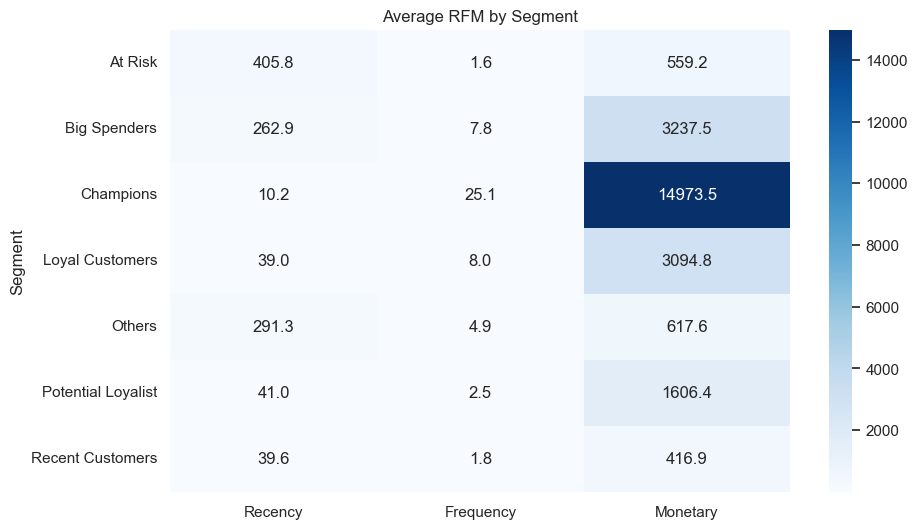

In [12]:
segment_mean = rfm.groupby("Segment")[["Recency", "Frequency", "Monetary"]].mean()

plt.figure(figsize=(10,6))
sns.heatmap(segment_mean, annot=True, fmt=".1f", cmap="Blues")
plt.title("Average RFM by Segment")
plt.show()


11) Export เป็นไฟล์เพื่อใช้ทำ K-Means ต่อ

In [13]:
output_path = "../data/processed/rfm_results.csv"
rfm.to_csv(output_path, index=True)

output_path


'../data/processed/rfm_results.csv'

12) Summary Insight อัตโนมัติ

In [14]:
for seg in rfm["Segment"].unique():
    print(f"\n------ {seg} ------")
    subset = rfm[rfm["Segment"] == seg]
    print("จำนวนลูกค้า:", len(subset))
    print("Recency เฉลี่ย:", round(subset["Recency"].mean(), 1))
    print("Frequency เฉลี่ย:", round(subset["Frequency"].mean(), 1))
    print("Monetary เฉลี่ย:", round(subset["Monetary"].mean(), 1))



------ Others ------
จำนวนลูกค้า: 154
Recency เฉลี่ย: 291.3
Frequency เฉลี่ย: 4.9
Monetary เฉลี่ย: 617.6

------ Champions ------
จำนวนลูกค้า: 636
Recency เฉลี่ย: 10.2
Frequency เฉลี่ย: 25.1
Monetary เฉลี่ย: 14973.5

------ Loyal Customers ------
จำนวนลูกค้า: 1269
Recency เฉลี่ย: 39.0
Frequency เฉลี่ย: 8.0
Monetary เฉลี่ย: 3094.8

------ At Risk ------
จำนวนลูกค้า: 2183
Recency เฉลี่ย: 405.8
Frequency เฉลี่ย: 1.6
Monetary เฉลี่ย: 559.2

------ Potential Loyalist ------
จำนวนลูกค้า: 265
Recency เฉลี่ย: 41.0
Frequency เฉลี่ย: 2.5
Monetary เฉลี่ย: 1606.4

------ Recent Customers ------
จำนวนลูกค้า: 782
Recency เฉลี่ย: 39.6
Frequency เฉลี่ย: 1.8
Monetary เฉลี่ย: 416.9

------ Big Spenders ------
จำนวนลูกค้า: 588
Recency เฉลี่ย: 262.9
Frequency เฉลี่ย: 7.8
Monetary เฉลี่ย: 3237.5
